# Design local geary c function in R

Author: *Ali Syed* and *Sihan Mao*

## 1. Setup

In [94]:
# try airbnb data for local moran and local geary comparison
# import packages
library(sf)          
library(spdep)
library(dplyr)
library(tidyverse)
library(stringr)
library(rgeos)
library(rgdal)
library(lubridate)
library(tmap)

In [2]:
#set the working directory 
setwd("D:/Auguste/UChicago/2018-2019/2019spring/GIS III//final project//airbnb")

Sample data: Chicago Airbnb data in 2015

In [3]:
airbnb <- read_sf('airbnb_Chicago 2015.shp', quiet = FALSE)

Reading layer `airbnb_Chicago 2015' from data source `D:\Auguste\UChicago\2018-2019\2019spring\GIS III\final project\airbnb\airbnb_Chicago 2015.shp' using driver `ESRI Shapefile'
Simple feature collection with 77 features and 20 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -87.94011 ymin: 41.64454 xmax: -87.52414 ymax: 42.02304
epsg (SRID):    4326
proj4string:    +proj=longlat +datum=WGS84 +no_defs


### 1.1 Sample Data Introduction

**Dataset Description**: The dataset is the test dataset of tutorial for calculating local Geary c in R. The test requires a continuous variable as the attribute of polygons. The dataset includes Airbnb rents and boundaries of community areas in Chicago.

**Type**: Polygon shapefile; Observations: 77; Variables: 3 

**Variables to be included**: 

- *community* - name of community area 
- *AREAID* – ID number associated with community area 
- *price_pp* – price per person of Airbnb

**Source**: 

1): GeoDa Center (https://geodacenter.github.io/data-and-lab//airbnb_Chicago-2015/), based on data from Chicago Data Portal (https://data.cityofchicago.org/);

2): Inside Airbnb (http://insideairbnb.com/get-the-data.html). 


## 2. Create neighbors and weights

In [4]:
# Calculate neighbours
nb2 <- poly2nb(airbnb, queen = FALSE)
nb2

listw2 <- nb2listw(nb2)

local2 <- localmoran(x = airbnb$income_pc, listw = nb2listw(nb2, style = "W"))

Neighbour list object:
Number of regions: 77 
Number of nonzero links: 370 
Percentage nonzero weights: 6.240513 
Average number of links: 4.805195 

## 3. Local Geary C 

Calculate global geary c from local geary c

- Local Geary c:

$$LG_i = \sum_{j=1}^{n}w_{ij}(x_i-x_j)^2$$

small local Geary c implies similarity and positive spatial autocorrelation.

### 3.1 Calculate local Geary c

In [7]:
## create an empty vector for local geary c
ci2 = vector("double")

## calculate local geary c 
for (i in 1:(length(airbnb$income_pc))) {
  ci2[i] = sum((airbnb$income_pc[i] - airbnb$income_pc[nb2[[i]]])^2)/length(nb2[[i]])
}

summary(ci2)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
4.910e+06 3.689e+07 8.253e+07 1.726e+08 1.993e+08 1.208e+09 

**ci2** is the local geary c statistic created for each polygon.

### 3.2 Visualize local Geary c

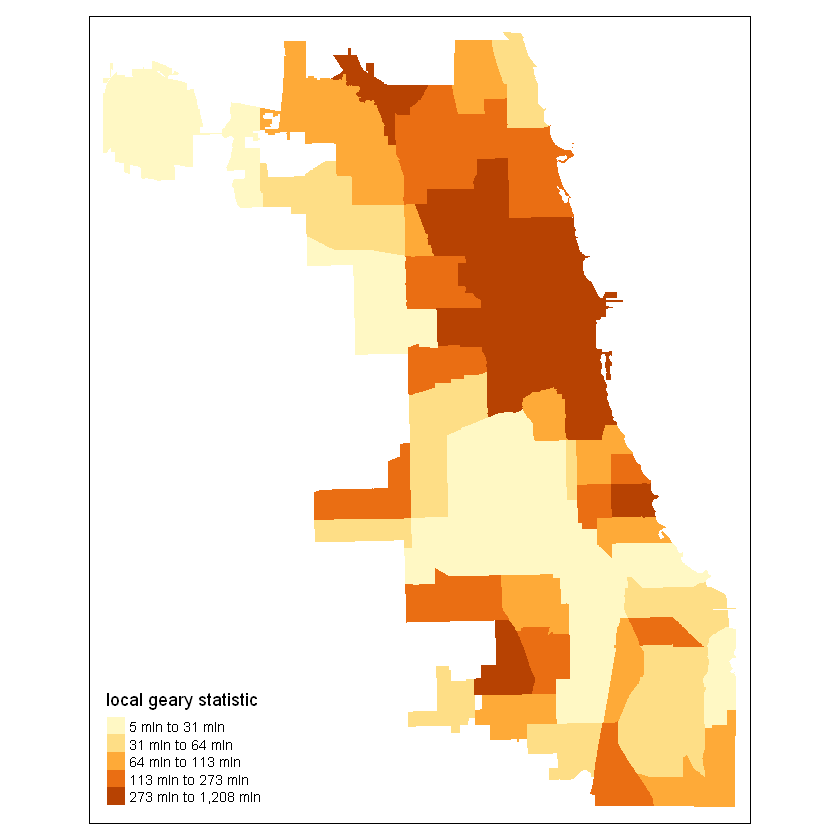

In [8]:
gearymap <- cbind(airbnb, ci2)
tm_shape(gearymap) + tm_fill(col = "ci2", style = "quantile", title = "local geary statistic")

### 3.3 Verify local Gear c with global Geary

- Global Geary c: 

$$C = \frac{(n-1)}{2\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}} \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_i-x_j)^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

In [22]:
## calculate global geary c
sum(ci2)/(var(airbnb$income_pc)*2*77)

[1] 0.369054

Compare with global geary c from function geary.test

In [28]:
# compare with geary c function
geary.test(airbnb$income_pc,listw2)


	Geary C test under randomisation

data:  airbnb$income_pc 
weights: listw2 

Geary C statistic standard deviate = 7.4298, p-value = 5.439e-14
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
      0.369053984       1.000000000       0.007211626 


Manually calculated global geary c is consistent with the result from geary test function, which indicates that the computed local geary c is correct. 

## 4. Permutation and Significance

Calculating local Geary c is not the last step of spatial autocorrelation analysis. *"An important methodological issue associated with the local spatial autocorrelation statistics is the selection of the p-value cut-off to properly reflect the desired Type I error."*$^1$

Permutation is required to simulate spatial randomness in order to generate plausible p-values for local Gear c statistics.

### 4.1 Significance and Permutation

*Still working on creating permutation functions from python community*

Instead, we generate p-value using normal distribution for convenience.

In [26]:
n <- nrow(airbnb)
res <- matrix(nrow=n, ncol=5)
colnames(res) <- c("c", "E.c", "Std.c", "Z.c", "P-value")

In [54]:
res[,1] <- ci2
res[,2] <- mean(res[,1]) 
res[,3] <- sqrt(var(res[,1]) / (n-1))
res[,4] <- (res[,1] -res[,2]) / res[,3]
res[,5] <- 2 * pnorm(abs(res[,4]), lower.tail=FALSE)
head(res)

c,E.c,Var.c,Z.c,P-value
331055382,172627846,26635617,5.9479583,2.715078e-09
105311067,172627846,26635617,-2.5273220,1.149361e-02
61979389,172627846,26635617,-4.1541542,3.264930e-05
81693238,172627846,26635617,-3.4140230,6.401117e-04
147380676,172627846,26635617,-0.9478726,3.431943e-01
157423182,172627846,26635617,-0.5708396,5.681084e-01


### 4.2 Match $LG_I$ with small deviations to local morans' I quadrent

*Need to establish on the function of permutation in order to filter out significant polygons*.

"The locations identified as significant and with the Local Geary statistic smaller than its mean, suggest positive spatial autocorrelation (small differences imply similarity). For those observations that can be classified in the upper-right or lower-left quadrants of a matching Moran scatter plot, we can identify the association as high-high or low-low. However, given that the squared difference can cross the mean, there may be observations for which such a classification is not possible. We will refer to those as other positive spatial autocorrelation."$^2$

In [62]:
# matching Moran scatter plot
quadrant_m <- vector(mode="numeric",length=nrow(local2))

# centers the variable of interest around its mean
mean_income <- airbnb$income_pc - mean(airbnb$income_pc)       

# builds a data quadrant
quadrant_m[mean_income >0 & m.local2>0] <- 4  
quadrant_m[mean_income <0 & m.local2<0] <- 1      
quadrant_m[mean_income <0 & m.local2>0] <- 2
quadrant_m[mean_income >0 & m.local2<0] <- 3

In [87]:
# categorize local geary c
quadrant_c <- vector(mode="numeric",length=nrow(local2))

# significance threshold
signif_c <- 0.01 

# centers the local Geary around the mean
m.geary <- res[,1] - res[,2]  

# builds a data quadrant
quadrant_c[quadrant_m == 4 & m.geary < 0] <- 4  ## high-high
quadrant_c[quadrant_m == 1 & m.geary < 0] <- 3  ## low-low    
quadrant_c[m.geary > 0] <- 2 ## negative
quadrant_c[quadrant_m == 2 & m.geary < 0]<- 1 ## other positive
quadrant_c[quadrant_m == 3 & m.geary < 0] <- 1 ## other positive
quadrant_c[res[,5]>signif_c] <- 0  

In [88]:
res_cat <- cbind(res, quadrant_m, quadrant_c)

In [91]:
res_cat[quadrant_c == 4]

numeric(0)

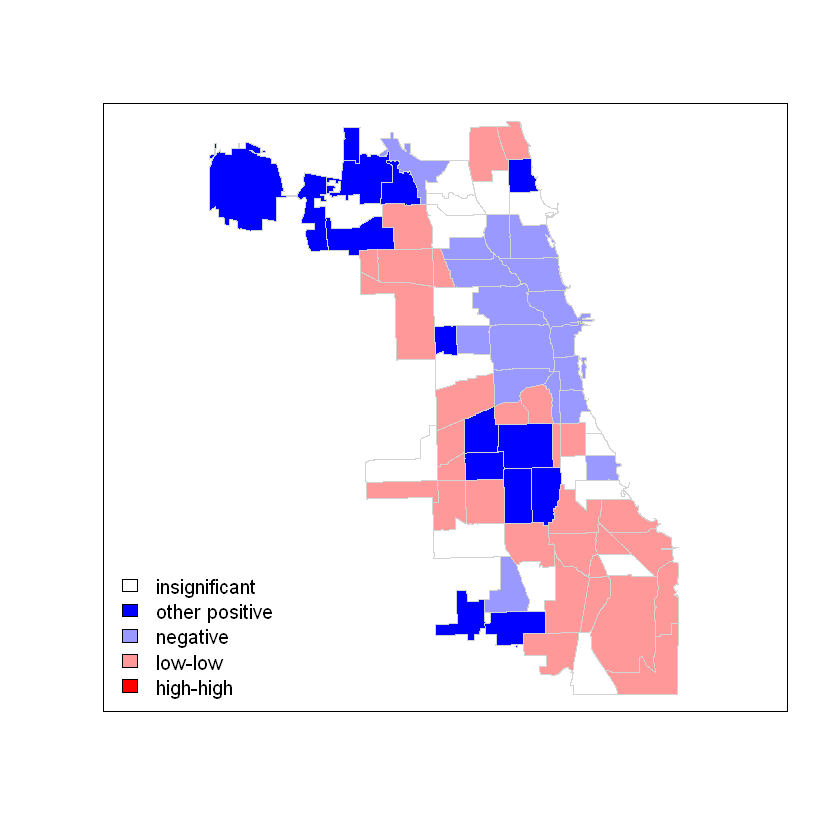

In [90]:
# plot in r
brks <- c(0,1,2,3,4)
colors <- c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(airbnb[0], border="lightgray",col=colors[findInterval(quadrant_c,brks,all.inside=FALSE)])
box()
legend("bottomleft",legend=c("insignificant","other positive","negative","low-low","high-high"),
       fill=colors,bty="n")

### 4.3 Visualize local Geary c

Variable "Ii" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.


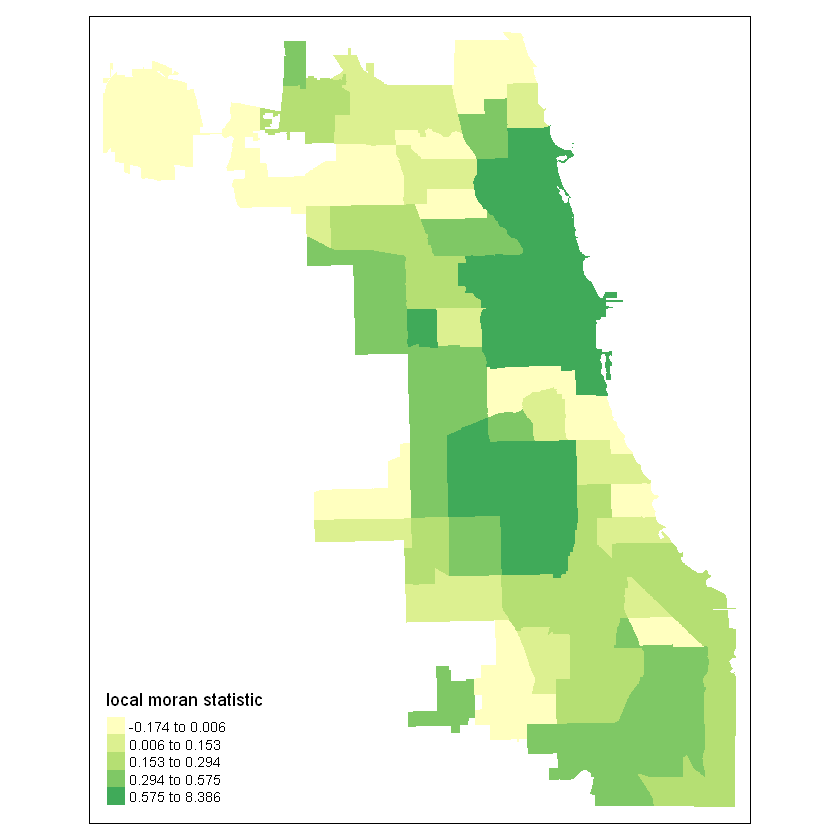

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.03013 -0.03013 -0.03013 -0.03013 -0.03013 -0.03013 

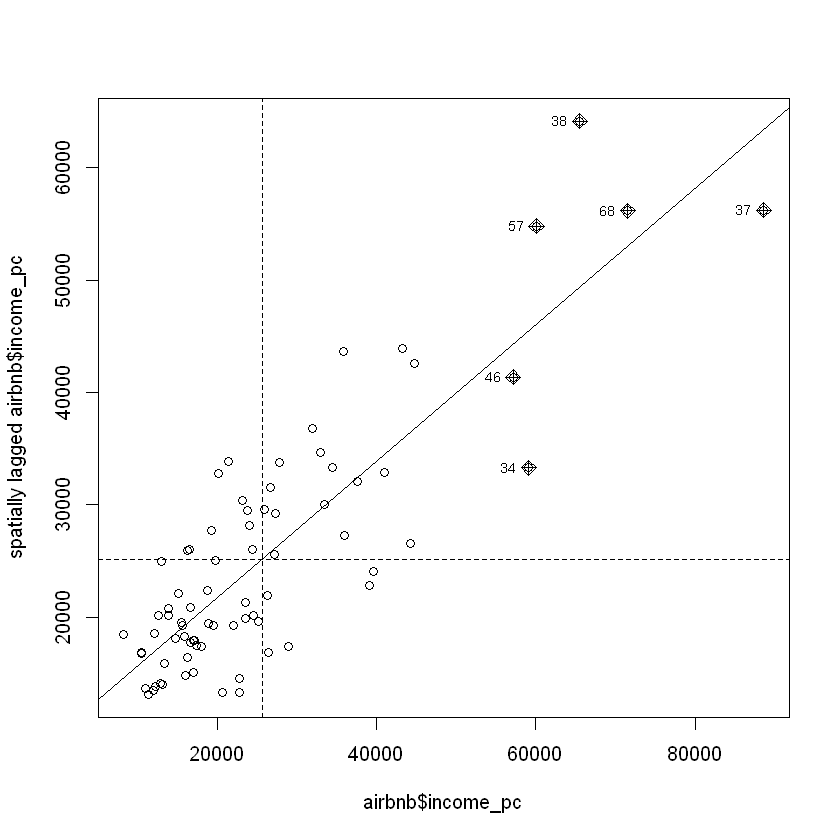

In [9]:
moranmap <- cbind(airbnb, local2)
tm_shape(moranmap) + tm_fill(col = "Ii", style = "quantile", title = "local moran statistic")

moran <- moran.plot(airbnb$income_pc, listw = nb2listw(nb2, style = "W"))
summary(local2[1])

### 4.4 Compare with local Moran's I 

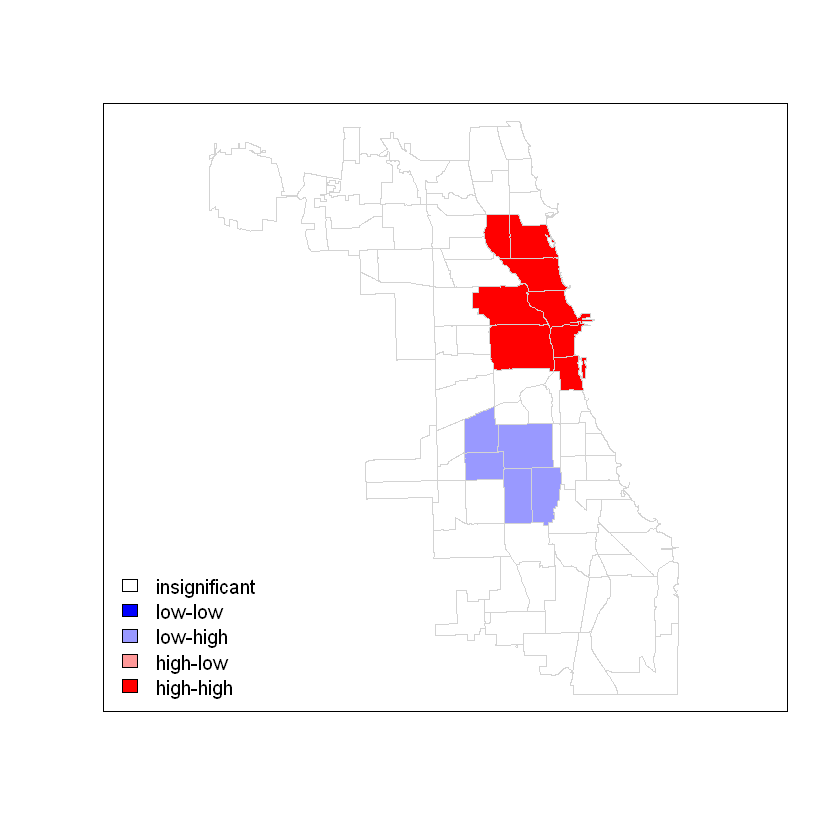

In [52]:
### create LISA map with significance 
### to create LISA cluster map ### 
quadrant <- vector(mode="numeric",length=nrow(local2))

# centers the variable of interest around its mean
mean_income <- airbnb$income_pc - mean(airbnb$income_pc)     

# centers the local Moran's around the mean
m.local2 <- local2[,1] - mean(local2[,1])    

# significance threshold
signif <- 0.05 

# builds a data quadrant
quadrant[mean_income >0 & m.local2>0] <- 4  
quadrant[mean_income <0 & m.local2<0] <- 1      
quadrant[mean_income <0 & m.local2>0] <- 2
quadrant[mean_income >0 & m.local2<0] <- 3
quadrant[local2[,5]>signif] <- 0   

# plot in r
brks <- c(0,1,2,3,4)
colors <- c("white","blue",rgb(0,0,1,alpha=0.4),rgb(1,0,0,alpha=0.4),"red")
plot(airbnb[0], border="lightgray",col=colors[findInterval(quadrant,brks,all.inside=FALSE)])
box()
legend("bottomleft",legend=c("insignificant","low-low","low-high","high-low","high-high"),
       fill=colors,bty="n")

## 5. Citation

1. Anselin, Luc. 2019. "Local Spatial Autocorrelation: Univariate Local Statistics", *Center for Spatial Data Science at University of Chicago.* 

2. *ibid*